
# TPU training with PyTorch Lightning

* **Author:** PL team
* **License:** CC BY-SA
* **Generated:** 2021-12-04T16:53:07.915320

In this notebook, we'll train a model on TPUs. Updating one Trainer flag is all you need for that. The most up to documentation related to TPU training can be found [here](https://pytorch-lightning.readthedocs.io/en/latest/advanced/tpu.html).

---
Open in [Open In Colab{height="20px" width="117px"}](https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/lightning_examples/mnist-tpu-training.ipynb)

Give us a ⭐ [on Github](https://www.github.com/PytorchLightning/pytorch-lightning/)
| Check out [the documentation](https://pytorch-lightning.readthedocs.io/en/latest/)
| Join us [on Slack](https://join.slack.com/t/pytorch-lightning/shared_invite/zt-pw5v393p-qRaDgEk24~EjiZNBpSQFgQ)

## Setup
This notebook requires some packages besides pytorch-lightning.

In [ ]:
! pip install --quiet "torch>=1.6, <1.9" "pytorch-lightning>=1.3" "torchvision" "torchmetrics>=0.3"

###  Install Colab TPU compatible PyTorch/TPU wheels and dependencies

In [ ]:
! pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl

In [ ]:
import torch
import torch.nn.functional as F
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchmetrics.functional import accuracy
from torchvision import transforms

# Note - you must have torchvision installed for this example
from torchvision.datasets import MNIST

BATCH_SIZE = 1024

### Defining The `MNISTDataModule`

Below we define `MNISTDataModule`. You can learn more about datamodules
in [docs](https://pytorch-lightning.readthedocs.io/en/latest/extensions/datamodules.html).

In [ ]:
class MNISTDataModule(LightningDataModule):
    def __init__(self, data_dir: str = "./"):
        super().__init__()
        self.data_dir = data_dir
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

        # self.dims is returned when you call dm.size()
        # Setting default dims here because we know them.
        # Could optionally be assigned dynamically in dm.setup()
        self.dims = (1, 28, 28)
        self.num_classes = 10

    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=BATCH_SIZE)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=BATCH_SIZE)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=BATCH_SIZE)

### Defining the `LitModel`

Below, we define the model `LitMNIST`.

In [ ]:
class LitModel(LightningModule):
    def __init__(self, channels, width, height, num_classes, hidden_size=64, learning_rate=2e-4):

        super().__init__()

        self.save_hyperparameters()

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * width * height, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, num_classes),
        )

    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

### TPU Training

Lightning supports training on a single TPU core or 8 TPU cores.

The Trainer parameters `tpu_cores` defines how many TPU cores to train on (1 or 8) / Single TPU core to train on [1].

For Single TPU training, Just pass the TPU core ID [1-8] in a list.
Setting `tpu_cores=[5]` will train on TPU core ID 5.

Train on TPU core ID 5 with `tpu_cores=[5]`.

In [ ]:
# Init DataModule
dm = MNISTDataModule()
# Init model from datamodule's attributes
model = LitModel(*dm.size(), dm.num_classes)
# Init trainer
trainer = Trainer(max_epochs=3, progress_bar_refresh_rate=20, tpu_cores=[5])
# Train
trainer.fit(model, dm)

Train on single TPU core with `tpu_cores=1`.

In [ ]:
# Init DataModule
dm = MNISTDataModule()
# Init model from datamodule's attributes
model = LitModel(*dm.size(), dm.num_classes)
# Init trainer
trainer = Trainer(max_epochs=3, progress_bar_refresh_rate=20, tpu_cores=1)
# Train
trainer.fit(model, dm)

Train on 8 TPU cores with `tpu_cores=8`.
You might have to restart the notebook to run it on 8 TPU cores after training on single TPU core.

In [ ]:
# Init DataModule
dm = MNISTDataModule()
# Init model from datamodule's attributes
model = LitModel(*dm.size(), dm.num_classes)
# Init trainer
trainer = Trainer(max_epochs=3, progress_bar_refresh_rate=20, tpu_cores=8)
# Train
trainer.fit(model, dm)

## Congratulations - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the Lightning
movement, you can do so in the following ways!

### Star [Lightning](https://github.com/PyTorchLightning/pytorch-lightning) on GitHub
The easiest way to help our community is just by starring the GitHub repos! This helps raise awareness of the cool
tools we're building.

### Join our [Slack](https://join.slack.com/t/pytorch-lightning/shared_invite/zt-pw5v393p-qRaDgEk24~EjiZNBpSQFgQ)!
The best way to keep up to date on the latest advancements is to join our community! Make sure to introduce yourself
and share your interests in `#general` channel


### Contributions !
The best way to contribute to our community is to become a code contributor! At any time you can go to
[Lightning](https://github.com/PyTorchLightning/pytorch-lightning) or [Bolt](https://github.com/PyTorchLightning/lightning-bolts)
GitHub Issues page and filter for "good first issue".

* [Lightning good first issue](https://github.com/PyTorchLightning/pytorch-lightning/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* [Bolt good first issue](https://github.com/PyTorchLightning/lightning-bolts/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* You can also contribute your own notebooks with useful examples !

### Great thanks from the entire Pytorch Lightning Team for your interest !

[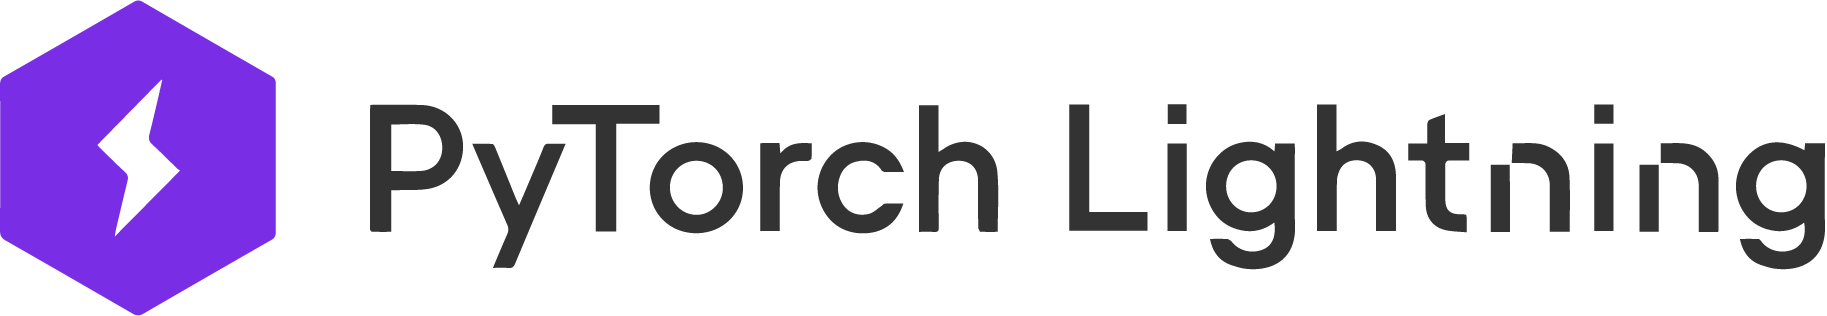{height="60px" width="240px"}](https://pytorchlightning.ai)